# Labelling Famous Landmarks (Transfer Learning) 

This notebook shows up one of the neural network model implementation for my data science project about the **Google Landmark Recognition 2020** dataset. The main objective with this step is applying transfer learning, carrying on the  hyperparameter tuning of the model and finally evaluating the results.

# Index of Contents

1.   Loading modules and data
2.   Preprocessing data
3.   Model Construction
4.   Evaluation



# Loading modules and data

Since I am using Google Colab, I linked my Google Drive just to access all the data downloaded from Kaggle. Also, by this way all the result and created files are easily stored on my unit.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For the model implementation I will make use of **Keras** library due to its simplicity and large community support.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.applications import Xception
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip, RandomRotation, RandomTranslation
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.optimizers.schedules import PolynomialDecay
from keras.initializers import GlorotNormal
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,  CategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [3]:
from tensorboard.plugins.hparams import api as hp
from sklearn.utils import class_weight
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf

# Load the TensorBoard notebook extension
%load_ext tensorboard

Checking the availability of the Google Colab free GPU for the model training.

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Extracting all the images from the Google Drive unit with which the model will be feeded.

In [5]:
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/train_200.zip'
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/val_200.zip'
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/test_200.zip'

Checking is everything is done correctly.

In [6]:
! ls -a 

.  ..  .config	drive  sample_data  ..test_200	..train_200  ..val_200


Set a seed to make reproducible experiments.

In [7]:
seed = 487
random.seed(seed)

In [8]:
train_csv = pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/train_200.csv")
train_csv.sample(5, random_state=seed)

,id,landmark_id,path
40243,d8c9f411e80e0b62,40088,../input/landmark-recognition-2020/train/d/8/c...
43574,e5988cfafb9152d4,113838,../input/landmark-recognition-2020/train/e/5/9...
5018,40a0c51d75e33888,120885,../input/landmark-recognition-2020/train/4/0/a...
39121,4ec75514a3a8bc71,76303,../input/landmark-recognition-2020/train/4/e/c...
53026,81c1d9b7f0868434,27190,../input/landmark-recognition-2020/train/8/1/c...


# Preprocessing data

Before starting with the model construction, it is convenient to prepare the data.

In [9]:
CLASSES = 200
BATCH_SIZE = 128
IMG_SIZE = (128, 128)
DATA_FORMAT = "channels_last"

In [10]:
train_dir = "..train_200"
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=seed)

val_dir = "..val_200"
val_dataset = image_dataset_from_directory(val_dir,
                                           shuffle=False,
                                           label_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE,
                                           seed=seed)

test_dir = "..test_200"
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=False,
                                            label_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed=seed)

Found 54761 files belonging to 200 classes.
Found 15446 files belonging to 200 classes.
Found 7801 files belonging to 200 classes.


Let's previsualize some bunch of photos from the train dataset, to check everything is loaded correctly.

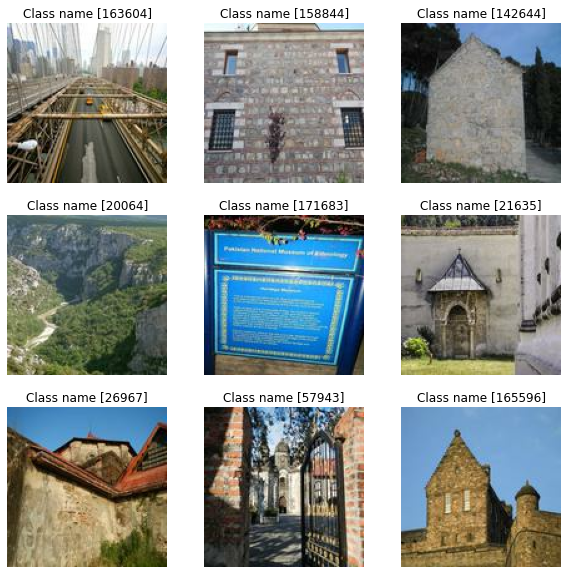

In [12]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Class name [{class_names[np.argmax(labels[i])]}]")
    plt.axis("off")

To load images from disk without I/O being blocked and boost the performance, it is highly recommended to use the buffered prefetching feature AUTOTUNE.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation
After several disastrous attempts of training the models with only the original images, I supposed that data augmentation technique could be one of the clues for improving the performance. Although the dataset is big enough, its special characteristic (intra-class variance) make the training process difficult to extract common features. The hypothesis that I came up with is that as every image is unique in each class, the model needs more examples to learn from. So, the idea is to generate on the fly "augmented" images from the original ones to facilitate more similar examples to the network in order to boost its accuracy.

In [14]:
data_augmentation = Sequential([
      RandomFlip("horizontal_and_vertical"),
      RandomZoom(0.2,0.2),
      RandomRotation(0.2),                        
], name="data_augmentation")

There are different ways of performing data augmentation with Keras, I ahve opted to make use of the experimental preprocessing layers instead of the classical ImageDataGenerator class. Let's see the result with some random photos.

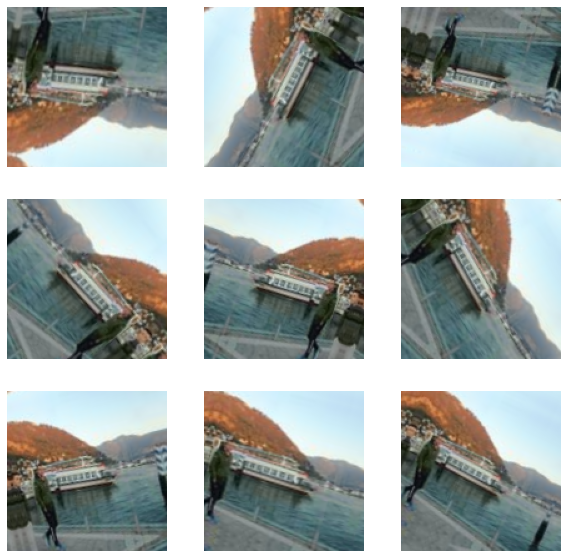

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Another important thing to consider is rescaling the pixel values, so let's create a separate layer for that specific task.

In [16]:
rescale = Sequential([
      Rescaling(1./255)
], name="rescale")

# Model Construction
Now it is time to build the model and for that I am going to use **Xception** as a base model. It is one of the different pre-trained models available on Keras. This tecnhique is called transfer learning because we are going to take the knowledge extracted from one dataset (ImageNet) and applied it to classify images from our.

The first thing to do is load all the weights and freeze all the layers.

In [17]:
pretrained_model = Xception(include_top=False, 
                            weights="imagenet",
                            input_shape=(*IMG_SIZE,3))
pretrained_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


Once created the pretrained model, we need to create the customized layers for our case. This part is known as the top block or classification head. 

In [18]:
# Create new model on top.
inputs = Input(shape=(*IMG_SIZE,3))
x = rescale(inputs)
# x = data_augmentation(x)
x = pretrained_model(x, training=False)
x = GlobalAveragePooling2D()(x)
# x = Flatten(data_format=DATA_FORMAT)(x)
# x = Dense(512, "relu")(x)
# x = Dropout(0.2)(x)
outputs = Dense(CLASSES, "softmax")(x)
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescale (Sequential)         (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               409800    
Total params: 21,271,280
Trainable params: 409,800
Non-trainable params: 20,861,480
_________________________________________________________________


Although the imbalance among classes was reduces on the **Data Cleaning** process, an significant gap stills remaining. The  weights for each class are calculated to make a better balanced and ensure a more accurate update of the neural network weights.

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_csv.landmark_id),
                                                 train_csv.landmark_id)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.784541547277937, 1: 0.784541547277937, 2: 1.2502511415525115, 3: 1.25598623853211, 4: 1.06955078125, 5: 0.784541547277937, 6: 1.2676157407407407, 7: 0.784541547277937, 8: 1.1130284552845529, 9: 1.1175714285714287, 10: 0.784541547277937, 11: 0.9126833333333333, 12: 1.0612596899224807, 13: 0.7936376811594202, 14: 1.0140925925925925, 15: 1.09522, 16: 0.784541547277937, 17: 0.784541547277937, 18: 1.0737450980392156, 19: 1.1130284552845529, 20: 1.2502511415525115, 21: 0.784541547277937, 22: 1.1801939655172413, 23: 1.2061894273127753, 24: 0.784541547277937, 25: 1.2915330188679246, 26: 0.8029472140762464, 27: 0.9344880546075085, 28: 0.8424769230769231, 29: 0.8692222222222222, 30: 0.784541547277937, 31: 1.1956550218340611, 32: 1.1956550218340611, 33: 1.27946261682243, 34: 1.2008991228070176, 35: 1.261774193548387, 36: 1.126769547325103, 37: 0.784541547277937, 38: 0.784541547277937, 39: 0.9709397163120568, 40: 1.126769547325103, 41: 0.8637381703470032, 42: 0.784541547277937, 43: 1.1552953

The competition metric is a common point for comparing the results of the model. It is a guide to follow for the tuning process.  

$GAP = \frac{1}{M}\sum_{i=1}^N P(i) rel(i)$ 

While searching how to code the formula I found several implementations, but not all were adapted for being used by Keras. So, I take one that was commonly used on different notebooks:

*   [Landmark Recognition Challenge - jandaldrop](https://github.com/jandaldrop/landmark-recognition-challenge/blob/master/landmarks-xception.ipynb)
*   [TF Keras EffNet B2 - Non Landmark Removal - Robert Smits](https://www.kaggle.com/rsmits/tf-keras-effnet-b2-non-landmark-removal)

The GAP is estimated by calculating it on each batch during training.



In [20]:
def GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

In [21]:
metrics = [GAP, "accuracy"]
EPOCHS = 10

# starter_learning_rate = 0.01
# end_learning_rate = 1e-4
# decay_steps = 10000
# learning_rate_fn = PolynomialDecay( starter_learning_rate,
#                                     decay_steps,
#                                     end_learning_rate,
#                                     power=0.5 )

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(), 
              metrics=metrics)

To train the model and keep track of what is happening inside this giant black box, it is a common practice to use checkpoints. They allow us to store valious information as the weights of the best models, the track of the metrics and other kind of parameters if they are needed. 

**TensorBoard** needs a special mention because it is a tool that makes things easy for the hyper-parameter tuning and also sharing with the community the results of the different experiments carried on.

In [24]:
#Dictionary as a log for the hyperparemeter tuning
hyperparameters = { 
    'classes': CLASSES,
    'img_size': IMG_SIZE[0],
    'batch': BATCH_SIZE,
    'data_augmentation': False,
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'decay': False, 
    'epochs': EPOCHS, 
    'dense_layers': 1
}

In [30]:
date = datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
LOG_DIR = f"/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs/Xception_feature_extraction_{date}"
CHECK_POINT = f"/content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_feature_extraction_{date}.h5"

callbacks = [
      EarlyStopping(monitor="val_accuracy", verbose=1, patience=3, mode="max", restore_best_weights=True), 
      ModelCheckpoint(filepath=CHECK_POINT, verbose=1, monitor="val_accuracy", mode="max", save_best_only=True),
      TensorBoard(log_dir=LOG_DIR, histogram_freq=1),
      hp.KerasCallback(LOG_DIR, hyperparameters)
]

with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                      epochs=EPOCHS,
                      callbacks=callbacks,
                      class_weight=class_weights,
                      validation_data=val_dataset)

Epoch 1/10
428/428 [==============================] - 94s 219ms/step - loss: 1.6354 - GAP: 0.3941 - accuracy: 0.6182 - val_loss: 2.0119 - val_GAP: 0.3094 - val_accuracy: 0.5243

Epoch 00001: val_accuracy improved from -inf to 0.52428, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_feature_extraction_25032021-172004.h5
Epoch 2/10
428/428 [==============================] - 93s 216ms/step - loss: 1.4495 - GAP: 0.4441 - accuracy: 0.6592 - val_loss: 1.9651 - val_GAP: 0.3219 - val_accuracy: 0.5352

Epoch 00002: val_accuracy improved from 0.52428 to 0.53515, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_feature_extraction_25032021-172004.h5
Epoch 3/10
428/428 [==============================] - 93s 216ms/step - loss: 1.3085 - GAP: 0.4927 - accuracy: 0.6942 - val_loss: 1.9275 - val_GAP: 0.3312 - val_accuracy: 0.5449

Epoch 00003: val_accuracy improved from 0.53515 to 0.54487, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/Xce

In [31]:
train_loss, train_gap, train_acc = model.evaluate(train_dataset)

428/428 [==============================] - 73s 170ms/step - loss: 0.6648 - GAP: 0.7375 - accuracy: 0.8558


In [32]:
val_loss, val_gap, val_acc = model.evaluate(val_dataset)

121/121 [==============================] - 20s 167ms/step - loss: 1.8805 - GAP: 0.3565 - accuracy: 0.5690


In [34]:
results = {
    'train_loss': round(train_loss,3) ,
    'train_acc': round(train_acc,3),
    'train_GAP': round(train_gap,3),
    'val_loss': round(val_loss,3),
    'val_acc': round(val_acc,3),
    'val_GAP': round(val_gap,3) 
}

In [35]:
log = {}
log.update(hyperparameters)
log.update(results)
log_csv = pd.DataFrame(log, index=[0])
log_csv.to_csv("/content/drive/MyDrive/4º de Carrera/TFG/log_Xception_feature_extraction.csv", index=False)

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name f"Xception_feature_extraction_{datetime.datetime.now().strftime("%d%m%Y-%H%M%S")}" \
  --description "Training results from  - TransferLearning Xception - notebook" \
  --one_shot

Once the model is trained, let's take a look to its performance through its history. The analysis give us clues about how well the model has learned, if it has overfit or underfit. In other words, it is the proof we have to make changes on the parameters.

In [46]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  gap = history.history['GAP']
  val_gap = history.history['val_GAP']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(7, 10))
  plt.subplot(3, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy',  linestyle='dashed', color="red")
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(3, 1, 2)
  plt.plot(gap, label='Training GAP')
  plt.plot(val_gap, label='Validation GAP', linestyle='dashed', color="red")
  plt.legend(loc='lower right')
  plt.ylabel('GAP')
  plt.title('Training and Validation GAP')

  plt.subplot(3, 1, 3)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss',  linestyle='dashed', color="red")
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  
  plt.show()

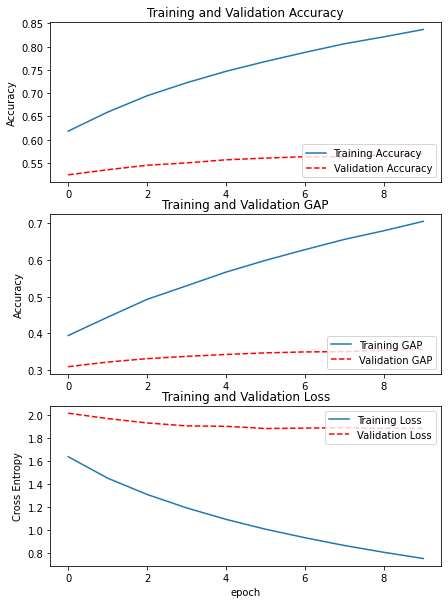

In [47]:
plot_history(history)

Another way of increasing the performance of the model is performing what is called a **fine-tuning** process. It is a tecnique that trains the weights of the pretrained model, "tuning" them or specializing them to the images of the current database. It is not recommended to unfreeze the entire model, just some of the top layers which are the most specialized.  Rather than overwriting the generic learning, fine-tuning aims to adapt these specialized features to work with the our dataset.

In [56]:
pretrained_model.trainable = True

print("Number of layers in the pretrained model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 128

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

FINE_TUNE_EPOCHS = 30
# starter_learning_rate = 0.001
# end_learning_rate = 1e-7
# decay_steps = 10000
# learning_rate_fn = PolynomialDecay(starter_learning_rate ,decay_steps,end_learning_rate, power=0.5)

model.compile(optimizer=RMSprop(learning_rate=1e-7),  
              loss=CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Number of layers in the pretrained model:  132
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescale (Sequential)         (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               409800    
Total params: 21,271,280
Trainable params: 3,573,448
Non-trainable params: 17,697,832
_________________________________________________________________


In [57]:
#Dictionary as a log for the hyperparemeter tuning
hyperparameters = { 
    'classes': CLASSES,
    'img_size': IMG_SIZE[0],
    'batch': BATCH_SIZE,
    'data_augmentation': False,
    'learning_rate': 1e-7,
    'optimizer': "RMSprop",
    'decay': False, 
    'epochs': FINE_TUNE_EPOCHS, 
    'freezed_layers': fine_tune_at,
    'dense_layers': 1
}

In [59]:
date = datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
LOG_DIR = f"/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs/Xception_fine_tuning_{date}"
CHECK_POINT = f"/content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_fine_tuning_{date}.h5"

callbacks = [
      EarlyStopping(monitor="val_accuracy", verbose=1, patience=4, mode="max", restore_best_weights=True),
      ModelCheckpoint(filepath=CHECK_POINT, verbose=1, monitor="val_accuracy", mode="max", save_best_only=True),
      TensorBoard(log_dir=LOG_DIR, histogram_freq=1),
      hp.KerasCallback(LOG_DIR, hyperparameters)
]

with tf.device('/device:GPU:0'):
  history_fine = model.fit(train_dataset,
                          epochs=FINE_TUNE_EPOCHS,
                          callbacks=callbacks,
                          class_weight=class_weights,
                          validation_data=val_dataset)

Epoch 1/30
428/428 [==============================] - 99s 230ms/step - loss: 0.4229 - GAP: 0.8278 - accuracy: 0.9077 - val_loss: 1.8894 - val_GAP: 0.3820 - val_accuracy: 0.5928

Epoch 00001: val_accuracy improved from -inf to 0.59284, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_fine_tuning_25032021-182800.h5
Epoch 2/30
428/428 [==============================] - 98s 227ms/step - loss: 0.4227 - GAP: 0.8275 - accuracy: 0.9078 - val_loss: 1.8894 - val_GAP: 0.3821 - val_accuracy: 0.5929

Epoch 00002: val_accuracy improved from 0.59284 to 0.59290, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_fine_tuning_25032021-182800.h5
Epoch 3/30
428/428 [==============================] - 97s 227ms/step - loss: 0.4226 - GAP: 0.8285 - accuracy: 0.9078 - val_loss: 1.8894 - val_GAP: 0.3823 - val_accuracy: 0.5930

Epoch 00003: val_accuracy improved from 0.59290 to 0.59303, saving model to /content/drive/MyDrive/4º de Carrera/TFG/Models/Xception_fine_tun

In [60]:
train_loss, train_gap, train_acc = model.evaluate(train_dataset)

428/428 [==============================] - 71s 165ms/step - loss: 0.4181 - GAP: 0.8277 - accuracy: 0.9082


In [61]:
val_loss, val_gap, val_acc = model.evaluate(val_dataset)

121/121 [==============================] - 20s 167ms/step - loss: 1.8896 - GAP: 0.3831 - accuracy: 0.5937


In [63]:
results = {
    'train_loss': round(train_loss,3) ,
    'train_acc': round(train_acc,3),
    'train_GAP': round(train_gap,3),
    'val_loss': round(val_loss,3),
    'val_acc': round(val_acc,3),
    'val_GAP': round(val_gap,3) 
}

In [64]:
log = {}
log.update(hyperparameters)
log.update(results)
log_csv= pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/log_Xception_fine_tuning.csv", index=False)
log_csv.append(log)
log_csc.to_csv("/content/drive/MyDrive/4º de Carrera/TFG/log_Xception_fine_tuning.csv", index=False)

Analyzing the learning curves of the fine tuning process.

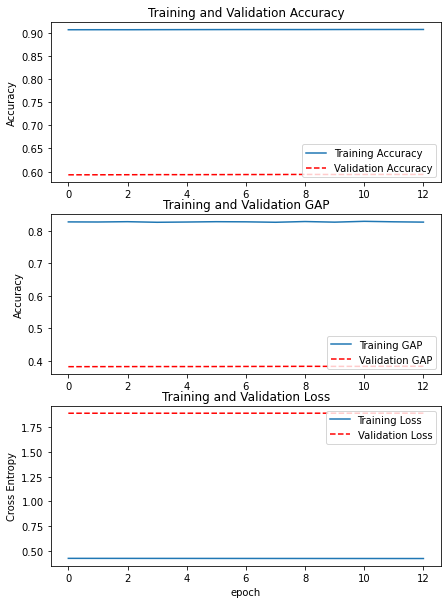

In [65]:
plot_history(history_fine)

# Evaluation

Finally, after a long time waiting and tuning parameters the model performance  can be evaluated with new data using the test set. This step only can be done once since this data is reserved with this unique purpose. Otherwise, it is consider a **data leak** and the entire process is automatically wrong.

Before starting with the evaluation, let's see some predictions from the validation dataset just for curiosity and trying to understand the results the model retrieves.

In [ ]:
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = [p.argmax() for p in predictions]

# Plot the predicted labels for certain images
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

So, these are the predictions the model gives for these images. Let's see now their true labels.

In [ ]:
# Plot the true labels for the same images
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_batch[i]])
  plt.axis("off")

The result is very bad, just one of the nine images is predicted correctly. To understand better the result, let's check some images from the predicted classes and see if there are elements of the photo that are leading our model to mispredictions.

The last step is evaluate the performance with test set and see how well the model generalizes on new data.

In [ ]:
loss, gap, acc = model.evaluate(test_dataset)

print('Test accuracy :', acc)
print('Test GAP :', gap)
print('Test sparse_topk_accuracy :', sparsetopk_acc)